In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

class MinMaxScaler3D(MinMaxScaler):
    """ Feature-wise scaling
        reshape data temporarily to [samples * time-steps , features] for feature-colums
        Code modified from https://stackoverflow.com/a/66650120,
        also https://stackoverflow.com/a/59601298"""
    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

class StandardScaler3D(StandardScaler):
    """ Feature-wise scaling
        reshape data temporarily to [samples * time-steps , features] for feature-colums
        Code modified from https://stackoverflow.com/a/66650120,
        also https://stackoverflow.com/a/59601298"""
    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)


# TODO
# rewrite for train and test set scaling
# for example, using model.fit(train_data)
# and then apply model.scale_ and model.mean_ to test_data.

# hint: actually, this is standard in sklearn
# use this scaler and do a unit test with manually calculated data for train & test set

## 1.1 Baseline model (MLP)

data.shape = (4000, 1500)


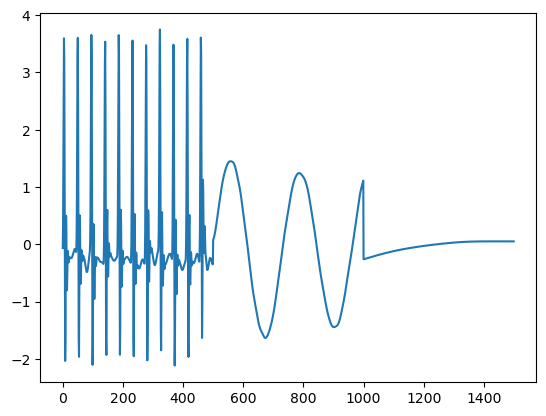

In [3]:
# Load data
data = np.load(Path(r"data/data.npy"))
target = np.load(Path(r"data/target.npy"))
groups = np.load(Path(r"data/groups.npy"))

# Scale data
data = StandardScaler3D().fit_transform(data)

# Reshape X to 1-D for MLP
data = np.reshape(data, (
    data.shape[0],
    data.shape[2]*data.shape[1]
), order="F")

plt.plot(data[142]);
print(f"{data.shape = }")

In [4]:
data = data.astype(np.float32)
target = target.astype(np.int64)

## Sklearn implementation


In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, GroupKFold

model = MLPClassifier(
    random_state=1, 
    max_iter=500, 
    early_stopping=True)

cv = GroupKFold()
test_score = cross_val_score(model, data, target, groups=groups, cv=cv,
                             n_jobs=5)
print(f"The average accuracy is "
      f"{test_score.mean():.3f} ± "
      f"{test_score.std():.3f}")

The average accuracy is 0.773 ± 0.034


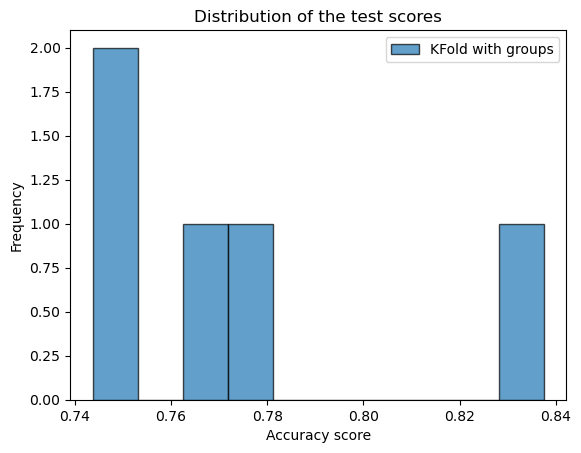

In [6]:
all_scores = pd.DataFrame(
    [test_score],
    index=["KFold with groups"],
).T

all_scores.plot.hist(bins=10, edgecolor="black", alpha=0.7)
plt.xlabel("Accuracy score")
_ = plt.title("Distribution of the test scores")

## Skorch implementation

In [7]:
print(f"{data.shape = }\n{target.shape = }\n{groups.shape = }")

data.shape = (4000, 1500)
target.shape = (4000,)
groups.shape = (4000,)


In [9]:
import numpy as np
from sklearn.datasets import make_classification
from torch import nn
from skorch import NeuralNetClassifier

class MyModule(nn.Module):
    def __init__(self, num_units=1000):
        super().__init__()

        self.dense0 = nn.Linear(1500, num_units)
        self.nonlin = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, num_units)
        self.output = nn.Linear(num_units, 2)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, X, **kwargs):

        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = self.nonlin(self.dense1(X))
        X = self.softmax(self.output(X))
        return X

net = NeuralNetClassifier(
    MyModule,
    max_epochs=20,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

net.fit(data, target)
y_proba = net.predict_proba(data)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4075       0.8538        0.2835  0.3178
      2        0.3548       0.8300        0.2903  0.3056
      3        0.3551       0.8525        0.2847  0.3211
      4        0.3558       0.8550        0.2825  0.3197
      5        0.3502       0.8363        0.2909  0.3124
      6        0.3488       0.8450        0.2873  0.2912
      7        0.3508       0.7525        0.3053  0.3139
      8        0.3498       0.8638        0.2866  0.3034
      9        0.3468       0.8213        0.2899  0.2905
     10        0.3460       0.8113        0.2923  0.3037
     11        0.3455       0.8075        0.2923  0.2963
     12        0.3458       0.8462        0.2860  0.3030
     13        0.3453       0.8625        0.2764  0.2868
     14        0.3446       0.8438        0.2868  0.3102
     15        0.3445       0.8475        0.2816  0.2895
     16        0.3450       0.8

In [10]:
cv = GroupKFold()
test_score = cross_val_score(net, data, target, groups=groups, cv=cv,
                             n_jobs=5)
print(f"The average accuracy is "
      f"{test_score.mean():.3f} ± "
      f"{test_score.std():.3f}")

The average accuracy is 0.780 ± 0.029


In [ ]:
# # in a pipeline

# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler

# pipe = Pipeline([
#     ('scale', StandardScaler()),
#     ('net', net),
# ])

# pipe.fit(X, y)
# y_proba = pipe.predict_proba(X)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6922       0.5950        0.6878  0.0359
      2        0.6938       0.6150        0.6852  0.0180
      3        0.6882       0.6150        0.6830  0.0189
      4        0.6842       0.6300        0.6799  0.0180
      5        0.6816       0.6200        0.6761  0.0160
      6        0.6805       0.6350        0.6733  0.0150
      7        0.6765       0.6450        0.6684  0.0160
      8        0.6734       0.6400        0.6640  0.0160
      9        0.6708       0.6350        0.6593  0.0160
     10        0.6615       0.6750        0.6541  0.0199


In [12]:
# with grid search
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)
params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
    'module__num_units': [100, 1000],
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(data, target)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ......lr=0.01, max_epochs=10, module__num_units=100; total time=   0.6s
[CV] END ......lr=0.01, max_epochs=10, module__num_units=100; total time=   0.5s
[CV] END ......lr=0.01, max_epochs=10, module__num_units=100; total time=   0.6s
[CV] END .....lr=0.01, max_epochs=10, module__num_units=1000; total time=   1.8s
[CV] END .....lr=0.01, max_epochs=10, module__num_units=1000; total time=   1.8s
[CV] END .....lr=0.01, max_epochs=10, module__num_units=1000; total time=   1.8s
[CV] END ......lr=0.01, max_epochs=20, module__num_units=100; total time=   1.2s
[CV] END ......lr=0.01, max_epochs=20, module__num_units=100; total time=   1.2s
[CV] END ......lr=0.01, max_epochs=20, module__num_units=100; total time=   1.1s
[CV] END .....lr=0.01, max_epochs=20, module__num_units=1000; total time=   3.7s
[CV] END .....lr=0.01, max_epochs=20, module__num_units=1000; total time=   3.6s
[CV] END .....lr=0.01, max_epochs=20, module__num